In this notebook we will fit a model to predict the `inquire_product` label using the TF-IDF vectorizer.

In [1]:
import pandas as pd
import numpy as np
import yaml
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score

from catboost import CatBoostClassifier

import optuna


In [2]:
# Let's define some functions to load and process the data
def load_data_from_yaml(file_path: str) -> list[dict]:
    """
    Load data from yaml file
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = yaml.safe_load(f)
    return data

def history_to_string(history_list: list[dict]) -> str:
    """
    Convert a list of conversation dictionaries to a single string containing only the content and role.
    """
    return history_list[-1]['content']

def yaml_to_df(file_path: str) -> pd.DataFrame:
    """
    Convert yaml data to pandas dataframe.
    """
    data = load_data_from_yaml(file_path)
    df = pd.DataFrame(data)
    return df


In [16]:
# Loading data and preparing it for the model
df = yaml_to_df('../data/conversations.yaml')
df['history'] = df['history'].apply(history_to_string)
df = df.drop(columns=['messages_uuid'], axis=1)
df = df.drop_duplicates(subset=['history'])
df.sample(n=10)

,history,inquire_product
68,нужна говядина и курица а ещё маринад,False
98,"да, котлеты например",False
17,да\nчто бы ты ещё порекомендовал для атмосферы?,False
58,ок ещё чай с жасмином в пакетиках любой бренд,False
5,закажи сковородку 26 см,False
82,"Найди куриное филе, яйца и молоко",False
36,маракуйя,False
42,"да, добавь петелинку",False
35,собери продукты для лёгкого ужина для двух чел...,False
34,меньшей жирности и подешевле,False


We are using synthetic data for model fitting. But we must use real data for evaluation and testing.

Let's create a train-test split.

I want to add all positive samples from the real data to the test dataset for the correct evaluation of the model.

In [4]:
positive_df = df[df['inquire_product'] == True]
negative_df = df[df['inquire_product'] == False]

# Add all positive samples from the real data to the test dataset and 10 negative samples
test_df = pd.concat([positive_df, negative_df.sample(n=13)])
train_df = df.drop(test_df.index)

In [5]:
X_test, y_test = test_df['history'], test_df['inquire_product']

In [6]:
# Load synthetic data and add it to the train dataset
with open('../data/synthetic_data.json', 'r', encoding='utf-8') as f:
    synthetic_data = json.load(f)
synthetic_df = pd.DataFrame(synthetic_data['questions'], columns=['history'])
synthetic_df['inquire_product'] = True

## Parameter tuning
Let's tune the parameters of the CatBoostClassifier for the best performance.

In [7]:
def objective(trial):
    params = {
        'synthetic_samples': trial.suggest_float('synthetic_samples', 0.1, 1.0),
        'eval_size': trial.suggest_float('eval_size', 0.1, 0.5),
        'max_df' : trial.suggest_float('max_df', 0.5, 0.99),
        'min_df' : trial.suggest_int('min_df', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'iterations': trial.suggest_int('iterations', 1000, 10000),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 2000),
        'loss_function': trial.suggest_categorical('loss_function', ['CrossEntropy', 'Logloss']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
    }

    RANDOM_SEED = 1210
    # Add synthetic data to the train dataset
    train = pd.concat([train_df, synthetic_df.sample(frac=params['synthetic_samples'], random_state=RANDOM_SEED)])
    train, eval_df = train_test_split(train, test_size=params['eval_size'], random_state=RANDOM_SEED)
    X_train, y_train = train['history'], train['inquire_product']
    X_eval, y_eval = eval_df['history'], eval_df['inquire_product']
    vectorizer = TfidfVectorizer(max_df=params['max_df'], min_df=params['min_df'])
    X_train = vectorizer.fit_transform(X_train)
    X_eval = vectorizer.transform(X_eval)
    test = vectorizer.transform(X_test)
    catboost_model = CatBoostClassifier(iterations=params['iterations'], early_stopping_rounds=params['early_stopping_rounds'],
                                        learning_rate=params['learning_rate'], loss_function=params['loss_function'],
                                        max_depth=params['max_depth'], use_best_model=True, verbose=0,
                                        bootstrap_type=params['bootstrap_type'], random_strength=params['random_strength'],
                                        # class_weights={False: 1, True: 2},
                                        random_seed=RANDOM_SEED)
    catboost_model.fit(X_train, y_train, eval_set=(X_eval, y_eval))
    y_pred = catboost_model.predict(test)
    return f1_score(y_test, y_pred, average='binary')

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70, show_progress_bar=True, n_jobs=1)

study.best_params

  0%|          | 0/70 [00:00<?, ?it/s]

{'synthetic_samples': 0.8890971189579164,
 'eval_size': 0.18840368550581074,
 'max_df': 0.6634646438581575,
 'min_df': 2,
 'max_depth': 7,
 'learning_rate': 0.06097840439321487,
 'iterations': 6631,
 'early_stopping_rounds': 21,
 'loss_function': 'Logloss',
 'bootstrap_type': 'MVS',
 'random_strength': 0.0951724971782654}

# Implement the best parameters

In [8]:
RANDOM_SEED = 1210

In [9]:
train_df = pd.concat([train_df, synthetic_df.sample(frac=study.best_params['synthetic_samples'], random_state=RANDOM_SEED)])

In [10]:
train_df, eval_df = train_test_split(train_df, test_size=study.best_params['eval_size'], random_state=RANDOM_SEED)

In [11]:
X_train, y_train = train_df['history'], train_df['inquire_product']
X_eval, y_eval = eval_df['history'], eval_df['inquire_product']

print(f"Train dataset shape: {X_train.shape}")
print(f"Test dataset shape: {X_test.shape}")
print(f"Eval dataset shape: {X_eval.shape}")

Train dataset shape: (158,)
Test dataset shape: (20,)
Eval dataset shape: (37,)


In [12]:
# Vectorize the text
vectorizer = TfidfVectorizer(max_df=study.best_params['max_df'], min_df=study.best_params['min_df'])
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_eval = vectorizer.transform(X_eval)

In [13]:
catboost_model = CatBoostClassifier(iterations=study.best_params['iterations'], early_stopping_rounds=study.best_params['early_stopping_rounds'],
                                    use_best_model=True, learning_rate=study.best_params['learning_rate'],
                                    loss_function=study.best_params['loss_function'], max_depth=study.best_params['max_depth'],
                                    bootstrap_type=study.best_params['bootstrap_type'], random_strength=study.best_params['random_strength'],
                                    random_seed=RANDOM_SEED)

catboost_model.fit(X_train, y_train, eval_set=(X_eval, y_eval), verbose=True)

0:	learn: 0.6530080	test: 0.6609705	best: 0.6609705 (0)	total: 1ms	remaining: 6.64s
1:	learn: 0.6187721	test: 0.6426394	best: 0.6426394 (1)	total: 1.76ms	remaining: 5.83s
2:	learn: 0.5927933	test: 0.6130983	best: 0.6130983 (2)	total: 2.45ms	remaining: 5.41s
3:	learn: 0.5679881	test: 0.5948513	best: 0.5948513 (3)	total: 3.02ms	remaining: 5.01s
4:	learn: 0.5416663	test: 0.5739839	best: 0.5739839 (4)	total: 3.6ms	remaining: 4.77s
5:	learn: 0.5171397	test: 0.5638998	best: 0.5638998 (5)	total: 4.18ms	remaining: 4.62s
6:	learn: 0.4989884	test: 0.5526421	best: 0.5526421 (6)	total: 4.76ms	remaining: 4.51s
7:	learn: 0.4842802	test: 0.5505244	best: 0.5505244 (7)	total: 5.37ms	remaining: 4.44s
8:	learn: 0.4642179	test: 0.5446542	best: 0.5446542 (8)	total: 5.94ms	remaining: 4.37s
9:	learn: 0.4483077	test: 0.5332701	best: 0.5332701 (9)	total: 6.48ms	remaining: 4.29s
10:	learn: 0.4331732	test: 0.5139085	best: 0.5139085 (10)	total: 7.04ms	remaining: 4.24s
11:	learn: 0.4198335	test: 0.5055800	best: 0.

In [14]:
# test the model
y_pred = catboost_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.85      0.88        13
        True       0.75      0.86      0.80         7

    accuracy                           0.85        20
   macro avg       0.83      0.85      0.84        20
weighted avg       0.86      0.85      0.85        20



In [17]:
print(f"F1 score: {f1_score(y_test, y_pred, average='binary')}")

F1 score: 0.8


In [22]:
# Create DataFrame with features and their importance scores
feature_importance_df = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': catboost_model.feature_importances_
})

# Optionally sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

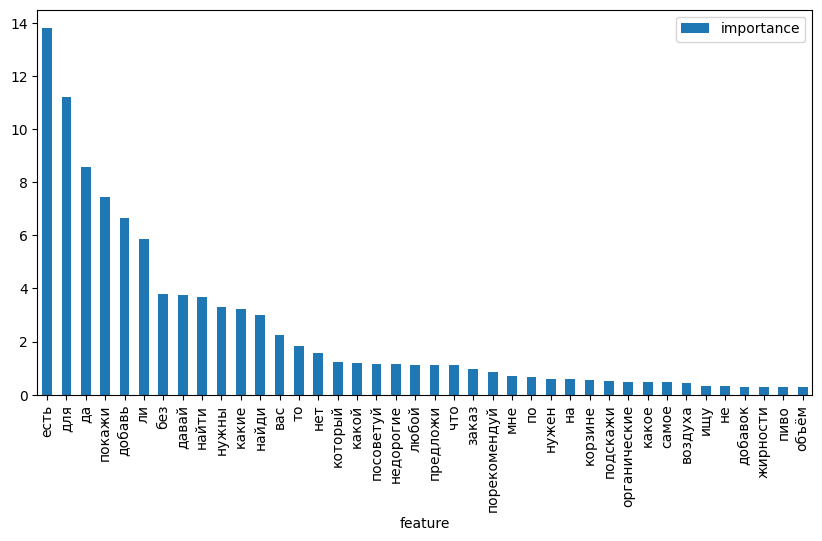

In [28]:
feature_importance_df.head(40).plot(kind='bar', x='feature', y='importance', figsize=(10, 5));